# Computer Lab 1: k-NN classifier

## Exercise 2 – Phoneme recognition

In this exercise, a real dataset will be employed. The dataset (file `speech_dataset.mat` in `/data/` folder) contains 5 features for each window of speech signal, with the aim to distinguish between nasal (class `1`) and oral sounds (class `2`). The five features are the normalized amplitudes of the five first harmonics of the speech signal. More information can be found here: https://www.openml.org/d/1489.

The data set contains features for 5404 speech samples (the 6-th column is the class label). The dataset has to be divided into training and test set. The activity to be done is the same as for the previous exercise. Make sure you do not use too many values of K, as computations might take a lot of time.

**Task**: your task is to implement a k-NN classifier in Matlab, which calculates the probability that a given test example belongs to each class, and outputs a class label as the class with the highest  probability. You will evaluate the classifier performance computing the average classification accuracy (i.e. the fraction of test examples that have been classified correctly).

In particular, you should perform the following:
* Split dataset into training and test set.
* Train a k-NN classifier for different values of k.
* Compare accuracy on the training set and the test set. Calculating accuracy of the training  set means that you will have to classify each sample in the training set as if it were a test sample; one expects that classification of training samples will perform well, and this may also be used to validate your implementation.
    * Accuracy is defined as the ratio between the number of test samples that are correctly classified, and the total number of test samples.
* Identifying overfitting and underfitting in the obtained results.

## Cross-validation
1. Holdout validation: it is a simple cross-validation approach to assess perfomance of the **kNN classification** model. It involves dividing the available dataset into two distinct subsets: a training set and a holdout set. The training set is used to train the machine learning model, while the holdout set is kept separate and only used after training to evaluate the model's performance on unseen data. Since the dataset is split into only two sets, the model is built just one time on the training set and executed faster.
    * **Drawback**
        * Single random split: different random splits may lead to different results, making it difficult to assess the true generalization ability of the model.
        * Underestimation of the bias of the model: holdout validation may underestimate the tendency to consistently favor one class over another. This is because the holdout set is not used during model training, and the model's bias may be inadvertently reflected in the training data.
        * Sensitivity to data distribution: this approach assumes that the data distribution is both constant and known. However, in real-world applications, data distribution may change over time or across different environments. Holdout validation may not be effective in these cases.
        * Unbalanced dataset: in the case of unbalanced datasets, one class has significantly fewer examples than the other classes. Then, holdout validation can be particularly problematic because the model may be overfitted to the majority class, leading to poor performance on the minority class when evaluated on the holdout set.
            * Dividing the dataset into a 70-30 training-testing split while preserving the original distribution of the two classes is a valid approach for holdout validation with imbalanced datasets. This ensures that the training set contains a representative sample of both classes, allowing the model to learn effectively from both majority and minority class data. The testing set also maintains the original class distribution, providing a realistic assessment of the model's generalization performance on unseen data.

### 0. Read Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

# Plots setting.
sns.set_context(
    'talk', rc = {
        'font.size': 12.0,
        'axes.labelsize': 10.0,
        'axes.titlesize': 10.0,
        'xtick.labelsize': 10.0,
        'ytick.labelsize': 10.0,
        'legend.fontsize': 10.0,
        'legend.title_fontsize': 12.0,
        'patch.linewidth': 2.0
        }
    )

data_sets = ['Train', 'Test']

In [2]:
# Check current folder.
os.getcwd()

'/content'

In [3]:
data_path = "/content/"

try:
    # Attempt to load the MATLAB data file.
    data = scipy.io.loadmat(data_path + f"speech_dataset.mat")

    print(
        f"Data ✓\n",
        f"Data Keys: {data.keys()}"
        )
except:
    print(f"Not found data! ({data_path})")

Data ✓
 Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'dataset'])


In [4]:
# Check the dataset structure.
data['dataset']

array([[ 0.489927, -0.451528, -1.04799 , -0.598693, -0.020418,  1.      ],
       [-0.641265,  0.109245,  0.29213 , -0.916804,  0.240223,  1.      ],
       [ 0.870593, -0.459862,  0.578159,  0.806634,  0.835248,  1.      ],
       ...,
       [ 0.246882, -0.793228,  1.190101,  1.423194, -1.303036,  2.      ],
       [-0.778907, -0.383111,  1.727029, -1.432389, -1.208085,  1.      ],
       [-0.794604, -0.640053,  0.632221,  0.72028 , -1.231182,  2.      ]])

### 1. Clean data & preliminary analysis

In [5]:
# This dictionary assigns meaningful names to the columns of the dataset.
data_cols = {
    0: 'f1',
    1: 'f2',
    2: 'f3',
    3: 'f4',
    4: 'f5',
    5: 'label'
}

# Converts the MATLAB data file into a Pandas DataFrame, making it easier to handle and analyze the data.
data_df = pd.DataFrame({data_cols[c]: data['dataset'][:,c] for c in np.arange(0, len(data_cols.keys()), 1)})

data_df.head()

,f1,f2,f3,f4,f5,label
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418,1.0
1,-0.641265,0.109245,0.292130,-0.916804,0.240223,1.0
2,0.870593,-0.459862,0.578159,0.806634,0.835248,1.0
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583,1.0
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127,1.0


In [6]:
# Check data types.
print(
    f"Data types:\n"
    f"{data_df.dtypes}\n\n"
    f"Labels: {data_df.label.unique()}\n\n"
    f"Null values for each feature:\n"
    f"{data_df.isna().sum(axis=0)}\n\n"
    f"Dataset lenght: {len(data_df)}\n\n"
    f"Duplicated data: {np.sum(data_df.duplicated())}"
    )

Data types:
f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
label    float64
dtype: object

Labels: [1. 2.]

Null values for each feature:
f1       0
f2       0
f3       0
f4       0
f5       0
label    0
dtype: int64

Dataset lenght: 5404

Duplicated data: 9


In [7]:
# Remove duplicated data.
data_df = data_df.drop_duplicates()

In [8]:
# Distribution of two labels in the datases.
print(
    f"Distribution for labels:\n"
    f"\t[1 2]\n"
    f"\t{(data_df.label.value_counts() / len(data_df)).values}"
    )

Distribution for labels:
	[1 2]
	[0.70769231 0.29230769]


### 2. Cross-Validation: splitting dataset into train and test sets

In [9]:
# Hold-out cross-validation approach (67% of data: train set, 33% of data: test set), preserving labels distributions on both train and test sets.
def data_holdout_split(df:pd.DataFrame, bin_feature:str, frac=0.67, s=1, verbose=False) -> tuple:

    """
    This function splits a pandas DataFrame into a training and testing set while preserving the original distribution of a binary class represented by the `bin_feature` column.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the data.
        bin_feature (str): The name of the column representing the binary class.
        frac (float, optional): The fraction of rows to be sampled for the training set. The default value is 0.67, which means that 67% of the rows will be used for training and the remaining 33% for testing.
        s (int, optional): The random seed for reproducibility. The default value is 1.
        verbose (bool, optional): A boolean flag indicating whether to print additional information about the splitting process. The default value is False.

    Returns:
        pd.DataFrame: The training set as a pandas DataFrame.
        pd.DataFrame: The testing set as a pandas DataFrame.
    """

    # Ensure that the 'bin_feature' column exists in the DataFrame.
    assert bin_feature in df.columns, f"Binary feature should be a data frame column."

    # Check that 'frac' is less than 1 to prevent oversampling the data.
    assert frac < 1, f"Fraction of sampled rows should be smaller than 1 (100%)."

    # Set the random seed for consistent splitting.
    np.random.seed(s)

    # Calculate the class distribution for the 'bin_feature' column.
    classes = data_df[bin_feature].value_counts() / len(data_df)

    train_set = []  # List to store the sampled data for the training set
    test_set = []  # List to store the remaining data for the testing set

    for class_label in tqdm(classes.index, colour='green'):
        class_data = df[df[bin_feature] == class_label]

        # Sample 67% of the data for the training set.
        sampled_data = class_data.sample(frac=frac, random_state=s)
        train_set.extend(sampled_data.values) # Add the sampled data to the training set.

        # Remaining data goes to testing set.
        remaining_data = class_data.drop(sampled_data.index)
        test_set.extend(remaining_data.values) # Add the remaining data to the testing set.

    # Rename data frames columns and set class type to int
    data_cols = {}

    for i in np.arange(0, len(data_df.columns), 1):
        data_cols[i] = data_df.columns[i]

    train_df = pd.DataFrame(train_set).rename(columns=data_cols)
    train_df[train_df.columns[-1]] = train_df[train_df.columns[-1]].astype(int)

    test_df = pd.DataFrame(test_set).rename(columns=data_cols)
    test_df[test_df.columns[-1]] = test_df[test_df.columns[-1]].astype(int)

    # Print information about the split data if 'verbose' is True.
    if verbose:
        print(
            f"Datasets sizes:\n",
            f"\tdataset length: {len(df)}\n"
            f"\ttrain set length: {len(train_df)}\n"
            f"\ttest set length: {len(test_df)}\n"
            f"\t({'Correct sizes ✓' if len(train_df) + len(test_df) == len(df) else 'Wrong sizes ✕'})\n",
            f"Distribution for labels:\n"
            f"\t\t\t[1 2]\n"
            f"\tdataset: \t{(df[df.columns[-1]].value_counts() / len(df)).values}\n"
            f"\ttrain set: \t{(train_df[train_df.columns[-1]].value_counts() / len(train_df)).values}\n"
            f"\ttest set: \t{(test_df[test_df.columns[-1]].value_counts() / len(test_df)).values}"
        )

    return train_df, test_df

In [10]:
train_df, test_df = data_holdout_split(data_df, 'label', verbose=True)

100%|██████████| 2/2 [00:00<00:00, 210.66it/s]

Datasets sizes:
 	dataset length: 5395
	train set length: 3615
	test set length: 1780
	(Correct sizes ✓)
 Distribution for labels:
			[1 2]
	dataset: 	[0.70769231 0.29230769]
	train set: 	[0.70760719 0.29239281]
	test set: 	[0.70786517 0.29213483]


### 3. kNN-Classification
The method implemented in [Synthetic dataset](/notebooks/01-synthetic-dataset.ipynb), `knn()` is not so efficient, since in the previous case there are only 100 data points, here there are more than 5000. Then a more efficient approach is needed.

The previous method works with `pd.DataFrame`, for a more immediate, simple and fast approach. Here, the use of `pd.DataFrame` implieas a lot of computational cost, then maybe the use of `np.array` can be more smart in order to reduce the time computation.

In [11]:
def knn_from_scratch(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, k: int = 3, bar: bool = True) -> np.ndarray:

    """
    This function implements the k-nearest neighbors classification algorithm for classifying data points from a test set based on a training set.

    Args:
        x_train (np.ndarray): A NumPy array containing the training data (features).
        y_train (np.ndarray): A NumPy array containing the training data (labels).
        x_test (np.ndarray): A NumPy array containing the testing data (features).
        k (int, optional): The number of nearest neighbors to consider for classification. Defaults to 3.
        bar (bool, optional): A parameter for showing the progress bar. Defaults to False (not showing).

    Returns:
        np.ndarray: A NumPy array containing the predicted labels for testing data.
    """

    # x_train = train_df.iloc[:,:-1].to_numpy()
    # y_train = train_df.iloc[:,-1].to_numpy()
    # x_test = test_df.iloc[:,:-2].to_numpy()

    # Initialize data structures
    M = len(x_test)
    N = len(x_train)

    # Validate k parameter
    assert (type(k) != float) and (k % 2 == 1), "k parameter should be an odd integer number."
    assert k < N, "k parameter should be smaller than the train set size."

    pred = np.zeros(M, dtype=int)

    D = np.zeros([M, N], dtype=float)  # Distance matrix
    E = np.zeros([M, k], dtype=int)  # Array of nearest neighbors

    for i in tqdm(np.arange(0, M, 1), colour='green', disable=bar): # For each test point
        for j in np.arange(0, N, 1): # For each training point
            D[i][j] = np.sqrt(np.sum((x_test[i] - x_train[j]) ** 2)) # Calculate euclidean distance between the points

        # Find indices of k nearest neighbors
        E[i] = np.argsort(D[i])[:k]

        l = np.sum(y_train[E[i]] == 1) >= (k + 1) / 2 # Check majority of labels (l)

        prediction = 1 if l else 2 # Assign prediction based on majority
        pred[i] = prediction  # Update prediction array with the calculated value

    return pred

#### 3.1 Method from scratch

In [12]:
data = {
    'Train': train_df,
    'Test': test_df
}
misclass_errs = {}

k_max = 50
k_vals = np.arange(1, k_max, 2)

for d_type in data_sets:
    misclass_errs[d_type] = []
    print(f"{d_type} set misclassification error:")
    for k in tqdm(k_vals, colour="green"):
        pred = knn_from_scratch(
                x_train=train_df.iloc[:,:-1].to_numpy(),
                y_train=train_df.iloc[:,-1].to_numpy(),
                x_test=data[d_type].iloc[:,:-1].to_numpy(),
                k=k)
        misclass_errs[d_type].append(np.sum(data[d_type].iloc[:,-1].values != pred) / len(data[d_type]))

Train set misclassification error:


100%|██████████| 25/25 [46:32<00:00, 111.68s/it]


Test set misclassification error:


100%|██████████| 25/25 [22:44<00:00, 54.58s/it]


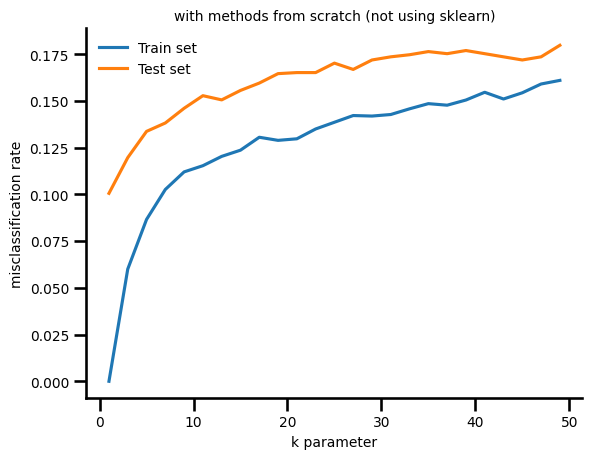

In [13]:
fig, ax = plt.subplots()

for d_type in data_sets:
    sns.lineplot(
        x=k_vals, y=misclass_errs[d_type],
        ax=ax,
        label=f"{d_type} set"
    )

ax.legend(framealpha=0)
ax.set_ylabel("misclassification rate")
ax.set_xlabel("k parameter")
ax.set_title("with methods from scratch (not using sklearn)")

sns.despine(right=True)

#### 3.2 Method from `sklearn`

In [14]:
# Implementing kNN method by using sklearn
x = k_vals
y = {}

for d_type in data_sets:
    y[d_type] = []
    print(f"{d_type} set:")
    for k in tqdm(k_vals, colour='green'):
        # Instantiate learning model
        neig = KNeighborsClassifier(n_neighbors=k)

        # Fitting the model
        neig.fit(train_df.iloc[:,:-1].values, train_df.iloc[:,-1].values)

        # Predict the response
        pred = neig.predict(data[d_type].iloc[:,:-1].values)

        # Evaluate misclassification error
        y[d_type].append(1 - accuracy_score(data[d_type].iloc[:,-1].values, pred))

Train set:


100%|██████████| 25/25 [00:07<00:00,  3.41it/s]


Test set:


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


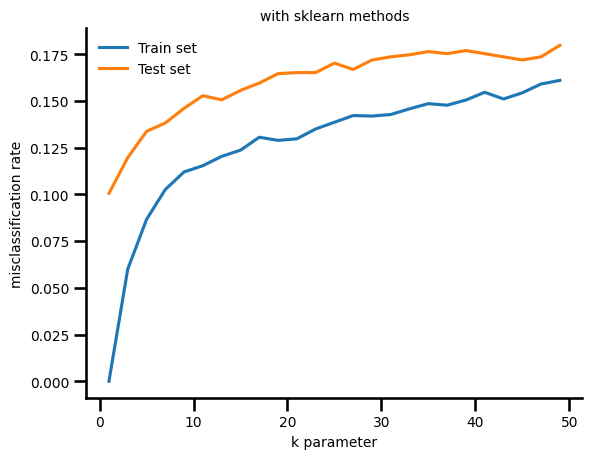

In [15]:
fig2, ax2 = plt.subplots()

for d_type in data_sets:
    sns.lineplot(
        x=k_vals, y=y[d_type],
        ax=ax2,
        label=f"{d_type} set"
    )

ax2.legend(framealpha=0)
ax2.set_ylabel("misclassification rate")
ax2.set_xlabel("k parameter")
ax2.set_title("with sklearn methods")

sns.despine(right=True)

---

In [ ]:
def knn(train_df: pd.DataFrame, test_df: pd.DataFrame, k: int = 3):
    # Initialize data structures
    M = len(test_set)  # Number of data points in the training set
    N = len(train_set)  # Number of data points in the test set

    # Validate k parameter
    assert (type(k) != float) and (k % 2 == 1), "k parameter should be an odd integer number."
    assert k < N, "k parameter should be smaller than the train set size."

    D = np.zeros([M, N], dtype=float)  # Distance matrix
    E = np.zeros([M, k], dtype=int)  # Array of nearest neighbors

    # Calculate distances between test set points and training set points
    for i in tqdm(np.arange(0, M, 1), colour='green'):  # For each test point
        for j in np.arange(0, N, 1):  # For each training point
            D[i][j] = euclidean(  # Calculate distance between the points
                test_set.loc[i][:-2].values,  # Current test point coordinates
                train_set.loc[j][:-1].values  # Corresponding training point coordinates
            )

        # Find the k nearest neighbors for each test point
        E[i] = np.argsort(D[i])[:k]  # Obtain the indices of the k nearest neighbors

        # Assign predictions based on majority of labels among the k nearest neighbors
        l1 = np.sum([int(train_set.loc[E[i][idx]][-1] == 1) for idx in np.arange(0, k)]) >= (k + 1) / 2
        l2 = np.sum([int(train_set.loc[E[i][idx]][-1] == 2) for idx in np.arange(0, k)]) >= (k + 1) / 2

        if l1:
            test_set.loc[i, 'prediction'] = 1
        elif l2:
            test_set.loc[i, 'prediction'] = 2

    return test_set  # Return the modified test set with predictions